In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import skimage as ski
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

In [0]:
def getpca(X):
    # %X: MxN matrix (M dimensions, N trials)
    # %Y: Y=P*X
    # %P: the transform matrix
    # %V: the variance vector

    [M, N] = X.shape

    mx = (np.mean(X, axis=1)).reshape((M, 1))

    X = X - mx

    CovX = (X @ X.T) / (N-1)
    [V, P]= np.linalg.eig(CovX)

    V_minus = -1 * V
    ind = np.argsort(V_minus, axis=0)

    V = V[ind];
    P = P[:, ind]

    P = P.T
    Y = np.matmul(P, X)
    # Y = P @ X

    return [Y, P, V, mx]

In [0]:
def blow_gray(B):
    [n, m] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m))

    A[0:n:2, 0:m:2] = B
    A[0:n:2, 1:m:2] = B
    A[1:n:2, 0:m:2] = B
    A[1:n:2, 1:m:2] = B

    return A

In [0]:
def LPG_new(X, row, col, off, nv, S, I):
    [N, M] = I.shape
    f2 = X.shape[1]

    rmin = max(row - S, 0)
    rmax = min(row + S + 1, N)
    cmin = max(col - S, 0)
    cmax = min(col + S + 1, M)

    # print("rmin, rmax, cmin, cmax: ", rmin, rmax, cmin, cmax)
    idx = I[rmin: rmax, cmin: cmax]
    idx = (idx.T).flatten()
    B = X[idx,:]
    v = X[off,:]

    dis = ((B[:, 0] - v[0])**2)
    dis = dis.reshape((dis.shape[0], 1))

    for k in range(1, f2):
        # print("k: ", k)
        # k = int(k/S)
        dis_partial = ((B[:, k] - v[k])**2)
        dis_partial = dis_partial.reshape((dis_partial.shape[0], 1))
        dis = dis + dis_partial

    dis = dis/f2
    ind = np.argsort(dis, axis=0)
    indc = idx[ind[0:nv]]

    return indc

In [0]:
def dim_reduction(X):
    n = X.shape[0]
    n = math.floor(n * 0.4)
    [coe, P, V, mX] = getpca(X)
    Y = P[0 : n, :] @ X
    return Y

In [0]:
def LPGPCA_denoising(noise_img, orig_img, std, profile, K):
    s = 2
    if profile == 'fast':
        s = 2
    elif profile == 'normal':
        s = 1

    [n, m] = orig_img.shape
    [h, w] = noise_img.shape

    ##############First stage denoising###############

    v2 = std**2
    #training block(2k + 1) * (2k + 1)
    S = 20
    # variable block(2t + 1) * (2t + 1)
    t = 3
    nblk = 250
    b = 2 * t + 1
    b2 = b * b

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T
    # I = (I.reshape((N, M))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            # px = np.clip((py - v2), a_min=0.0, a_max=np.max(py - v2))
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0
    for i in range(b):
        for j in range(b):
            # dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] = dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] + (Y[k, :]).reshape((N1, M1))
            # im_wei[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] = im_wei[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] + 1
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    # dI = np.fliplr(dI)
    # dI = np.rot90(dI)

    # plt.imsave('basic_lpgpca.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)
    psnr_1 = 0
    ssim_1 = 0

    plt.imshow(dI, cmap='gray')
    plt.show()

    row, col = orig_img.shape
    # psnr_1 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_1 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    orig_img_crop = orig_img.astype(dtype=np.int)
    dI_crop = dI.astype(dtype=np.int)
    psnr_1 = psnr(orig_img_crop, dI_crop)
    ssim_1 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()

    dif = dI[(K) : (n - K), (K) : (m - K)] - noise_img[(K) : (n - K), (K) : (m - K)]
    print ("mean diff: ", np.mean(dif**2))
    vd = std**2 - np.mean(dif**2)
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    #
    #-----------------------------------------------------------------
    # The second stage: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.36
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1)]
            # blk = noise_img[i : (h - b + i), j : (w - b + j)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            # px = max(0, py - v2)
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0

    for i in range(b):
        for j in range(b):
            # dI[(r + i), (c + j)] = dI[(r + i), (c + j)] + (Y[k , :].T).reshape((N1, M1))
            # im_wei[(r + i), (c + j)] = im_wei[(r + i), (c + j)] + 1
            # dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] = dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] + (Y[k, :].T).reshape((N1, M1))
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    # plt.imsave('final_lpgpca_int.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)

    # psnr_1 = csnr(orig_img, dI, K, K)
    # ssim_1 = cal_ssim(orig_img, dI, K, K)

    row, col = orig_img.shape
    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)], data_range=float)
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    orig_img_crop = orig_img.astype(dtype=np.int)
    dI_crop = dI.astype(dtype=np.int)
    psnr_2 = psnr(orig_img_crop, dI_crop)
    ssim_2 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()
    plt.imshow(dI, cmap='gray')
    plt.show()

    d_im = dI[K:n-K, K:m-K]

    return [d_im, psnr_1, ssim_1, psnr_2, ssim_2]

orig_img.shape:  (256, 256)
orig_img.max:  239.0
orig_img.min:  16.0


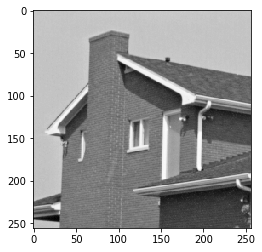

noise_img.shape:  (256, 256)
noise_img.max:  303.77071588269257
noise_img.min:  -30.90932899695389


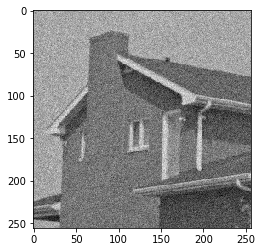

dI.max:  12320.696520249196
dI.min:  142.15427969458733
imwei.max:  49.0
imwei.min:  1.0
dI.max:  251.44278612753462
dI.min:  3.5970143409424225


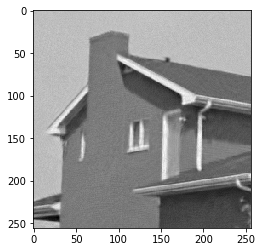

mean diff:  286.05574443235673
v1:  10.67446746061101
dI2.max:  248.80899874051428
dI2.min:  5.579957878164108


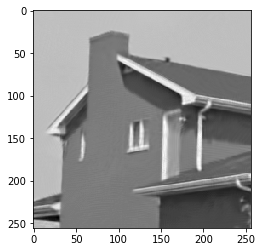

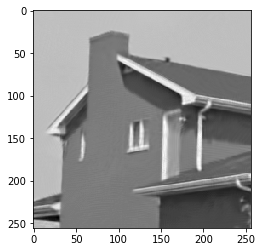

psnr1:  363.39266241085045
ssim1:  1.0
psnr2:  364.24217566126697
ssim2:  1.0


In [52]:
profile = 'normal'
# profile = 'fast'
std = 20
img_filename = 'house.tif'
orig_img = plt.imread(img_filename).astype(dtype=np.float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')

plt.imshow(denoise_img, cmap='gray')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


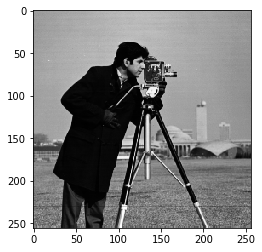

noise_img.shape:  (256, 256)
noise_img.max:  292.7040064340732
noise_img.min:  -75.21033385596448


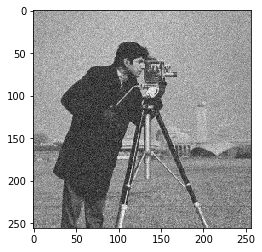

dI.max:  13403.266364886587
dI.min:  -1597.4870937223384
imwei.max:  49.0
imwei.min:  1.0
dI.max:  273.5360482629916
dI.min:  -32.60177742290487


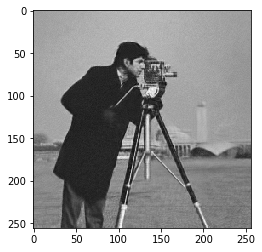

mean diff:  281.63750209822297
v1:  10.879453014824644
dI2.max:  272.17233046813544
dI2.min:  -28.7436399704458


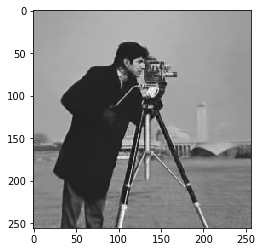

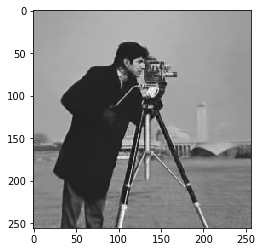

psnr1:  360.65195520039333
ssim1:  1.0
psnr2:  360.86981981143356
ssim2:  1.0


In [53]:
profile = 'normal'
# profile = 'fast'
std = 20
img_filename = 'cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=np.float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')

plt.imshow(denoise_img, cmap='gray')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


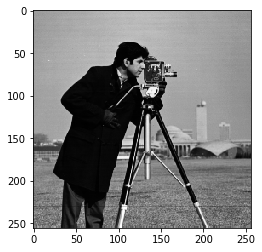

noise_img.shape:  (256, 256)
noise_img.max:  311.74305980620585
noise_img.min:  -63.18130891564756


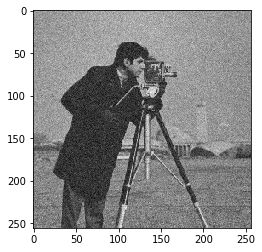

dI.max:  4292.185198798999
dI.min:  -296.0251300599796
imwei.max:  16.0
imwei.min:  1.0
dI.max:  277.39409470001243
dI.min:  -24.668760838331632


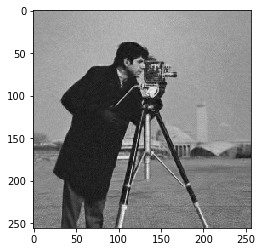

mean diff:  247.22421906197334
v1:  12.360250035417028
dI2.max:  273.4121435240375
dI2.min:  -21.5716084616964


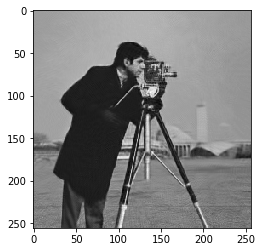

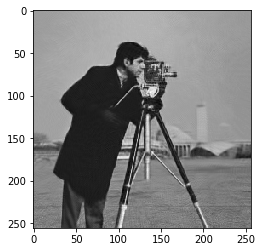

psnr1:  360.461587341382
ssim1:  1.0
psnr2:  361.09328593051464
ssim2:  1.0


In [54]:
# profile = 'normal'
profile = 'fast'
std = 20
img_filename = 'cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=np.float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width);

# [denoise_img, psnr1, ssim1, psnr2, ssim2] =\
#     LPGPCA_denoising(noise_img[:-1, :], orig_img[:-1, :], std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')

plt.imshow(denoise_img, cmap='gray')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

In [0]:
def blow_color(B):
    [n, m, ch] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m,ch))

    A[0:n:2, 0:m:2, :] = B
    A[0:n:2, 1:m:2, :] = B
    A[1:n:2, 0:m:2, :] = B
    A[1:n:2, 1:m:2, :] = B

    return A

In [0]:
def LPGPCA_color_denoising(noise_img, orig_img, std, profile, K):
    s = 2
    if profile == 'fast':
        s = 2
    elif profile == 'normal':
        s = 2

    [n, m, ch] = orig_img.shape
    [h, w, ch] = noise_img.shape

    ##############First stage denoising###############

    v2 = std**2
    #training block(2k + 1) * (2k + 1)
    S = 20
    # variable block(2t + 1) * (2t + 1)
    t = 3
    nblk = 250
    b = 2 * t + 1
    b2 = b * b

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2*ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            # px = np.clip((py - v2), a_min=0.0, a_max=np.max(py - v2))
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0
    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((N1, M1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[k+(2*b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    # dI = np.fliplr(dI)
    # dI = np.rot90(dI)

    # plt.imsave('basic_lpgpca.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)
    psnr_1 = 0
    ssim_1 = 0
    ssim_2 = 0
    ssim_3 = 0
    ssim_1   = (ssim_1+ ssim_2+ ssim_3)/3;

    plt.imshow(dI)
    plt.show()
    plt.imsave('denoised_first.png', dI)

    # row, col = orig_img.shape
    # psnr_1 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_1 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # orig_img_crop = orig_img.astype(dtype=np.int)
    # dI_crop = dI.astype(dtype=np.int)
    # psnr_1 = psnr(orig_img_crop, dI_crop)
    # ssim_1 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()

    dif_1 = dI[(K) : (n - K), (K) : (m - K), 0] - noise_img[(K) : (n - K), (K) : (m - K), 0]
    dif_2 = dI[(K) : (n - K), (K) : (m - K), 1] - noise_img[(K) : (n - K), (K) : (m - K), 1]
    dif_3 = dI[(K) : (n - K), (K) : (m - K), 2] - noise_img[(K) : (n - K), (K) : (m - K), 2]
    # print ("mean diff: ", np.mean(dif**2))
    vd_1 = std**2 - np.mean(dif_1**2)
    vd_2 = std**2 - np.mean(dif_2**2)
    vd_3 = std**2 - np.mean(dif_3**2)
    vd  = (vd_1 + vd_2 + vd_3)/3
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    #
    #-----------------------------------------------------------------
    # The second stage: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.37
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2 * ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            # px = max(0, py - v2)
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0

    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((N1, M1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[(k+2*b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    # plt.imsave('final_lpgpca_int.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)

    # psnr_1 = csnr(orig_img, dI, K, K)
    # ssim_1 = cal_ssim(orig_img, dI, K, K)

    # row, col = orig_img.shape
    psnr_2 = 0
    ssim_21 = 0
    ssim_22 = 0
    ssim_23 = 0
    ssim_2    = (ssim_21 + ssim_22 + ssim_23)/3
    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)], data_range=float)
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)

    # orig_img_crop = orig_img.astype(dtype=np.int)
    # dI_crop = dI.astype(dtype=np.int)
    # psnr_2 = psnr(orig_img_crop, dI_crop)
    # ssim_2 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()
    plt.imshow(dI)
    plt.show()
    plt.imsave('denoised_second.png', dI)

    d_im = dI[K:n-K, K:m-K, :]

    return [d_im, psnr_1, ssim_1, psnr_2, ssim_2]

orig_img.shape:  (481, 321, 3)
orig_img.max:  1.0
orig_img.min:  0.0


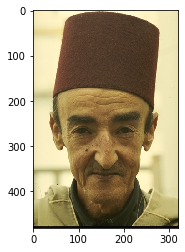

noise_img.shape:  (481, 321, 3)
noise_img.max:  1.0
noise_img.min:  0.0


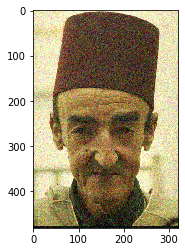

dI.max:  15.433756896495817
dI.min:  0.20426667233370244
imwei.max:  16.0
imwei.min:  1.0
dI.max:  0.9661784333884716
dI.min:  0.10649063455209963


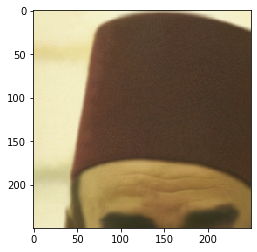

v1:  24.99982406550036
dI2.max:  0.9599934445051285
dI2.min:  0.11837093992387396


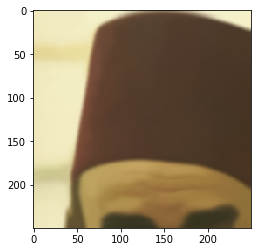

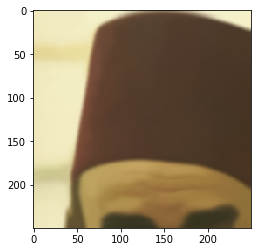

psnr1:  0
ssim1:  0.0
psnr2:  0
ssim2:  0.0


In [57]:
# profile = 'normal'
profile = 'fast'
std = 25
img_filename = '0038.png'
orig_img = plt.imread(img_filename).astype(dtype=np.float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

seed = 0
random.seed(seed)

# noise = np.random.normal(size=(orig_img.shape))
# noise[:, :, 0] = noise[:, :, 0]/np.sqrt(np.mean(noise[:, :, 0]**2))
# # noise[:, :, 1] = noise[:, :, 1]/np.sqrt(np.mean(noise[:, :, 1]**2))
# # noise[:, :, 2] = noise[:, :, 2]/np.sqrt(np.mean(noise[:, :, 2]**2))
# # noise_img = orig_img + (std * noise)
# noise_img = np.zeros((orig_img.shape))
# noise_img[:, :, 0] = orig_img[:, :, 0] + (std * noise[:, :, 0])
# noise_img[:, :, 1] = orig_img[:, :, 1] + (std * noise[:, :, 0])
# noise_img[:, :, 2] = orig_img[:, :, 2] + (std * noise[:, :, 0])
noise_img = plt.imread('0038_sig25.png').astype(dtype=np.float)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img)
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_color_denoising(noise_img[0:250, 0:250, :], orig_img[0:250, 0:250, :], std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')


plt.imshow(denoise_img)
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

In [58]:
orig_img = plt.imread('0038.png').astype(dtype=np.float)
orig_img = orig_img[:250, :250, :]
noise_img = plt.imread('0038_sig25.png').astype(dtype=np.float)
noise_img = noise_img[:250, :250, :]
denoise1_img = plt.imread('denoised_first.png').astype(dtype=np.float)
denoise2_img = plt.imread('denoised_second.png').astype(dtype=np.float)

denoise1_img = denoise1_img[:, :, 0:3]
denoise2_img = denoise2_img[:, :, 0:3]

print("denoise1_img.shape: ", denoise1_img.shape)
print("denoise2_img.shape: ", denoise2_img.shape)
psnr_1 = psnr(orig_img, denoise1_img)
ssim_1 = ssim(orig_img, denoise1_img, multichannel=True)
psnr_2 = psnr(orig_img, denoise2_img)
ssim_2 = ssim(orig_img, denoise2_img, multichannel=True)

print("psnr1: ", psnr_1)
print("ssim1: ", ssim_1)
print("psnr2: ", psnr_2)
print("ssim2: ", ssim_2)

denoise1_img.shape:  (250, 250, 3)
denoise2_img.shape:  (250, 250, 3)
psnr1:  28.95217187226749
ssim1:  0.9228980043405174
psnr2:  26.854462901244407
ssim2:  0.9112630687908658


orig_img.shape:  (481, 321, 3)
orig_img.max:  1.0
orig_img.min:  0.0


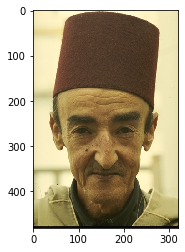

noise_img.shape:  (481, 321, 3)
noise_img.max:  1.0
noise_img.min:  0.0


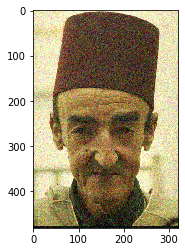

dI.max:  15.415890230894089
dI.min:  0.2043137312438339
imwei.max:  16.0
imwei.min:  1.0
dI.max:  0.9661594791412353
dI.min:  0.10988104881811889


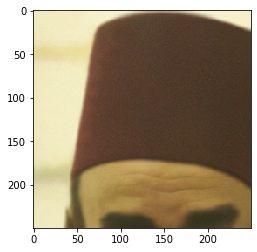

v1:  24.999833610172754
dI2.max:  0.9607380592755611
dI2.min:  0.11951105461566734


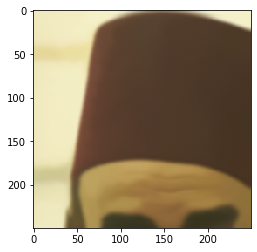

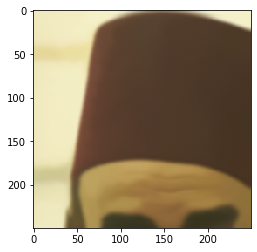

psnr1:  0
ssim1:  0.0
psnr2:  0
ssim2:  0.0


In [59]:
profile = 'normal'
# profile = 'fast'
std = 25
img_filename = '0038.png'
orig_img = plt.imread(img_filename).astype(dtype=np.float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

seed = 0
random.seed(seed)

# noise = np.random.normal(size=(orig_img.shape))
# noise[:, :, 0] = noise[:, :, 0]/np.sqrt(np.mean(noise[:, :, 0]**2))
# # noise[:, :, 1] = noise[:, :, 1]/np.sqrt(np.mean(noise[:, :, 1]**2))
# # noise[:, :, 2] = noise[:, :, 2]/np.sqrt(np.mean(noise[:, :, 2]**2))
# # noise_img = orig_img + (std * noise)
# noise_img = np.zeros((orig_img.shape))
# noise_img[:, :, 0] = orig_img[:, :, 0] + (std * noise[:, :, 0])
# noise_img[:, :, 1] = orig_img[:, :, 1] + (std * noise[:, :, 0])
# noise_img[:, :, 2] = orig_img[:, :, 2] + (std * noise[:, :, 0])
noise_img = plt.imread('0038_sig25.png').astype(dtype=np.float)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img)
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_color_denoising(noise_img[0:250, 0:250, :], orig_img[0:250, 0:250, :], std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')


plt.imshow(denoise_img)
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

In [60]:
orig_img = plt.imread('0038.png').astype(dtype=np.float)
orig_img = orig_img[:250, :250, :]
noise_img = plt.imread('0038_sig25.png').astype(dtype=np.float)
noise_img = noise_img[:250, :250, :]
denoise1_img = plt.imread('denoised_first.png').astype(dtype=np.float)
denoise2_img = plt.imread('denoised_second.png').astype(dtype=np.float)

denoise1_img = denoise1_img[:, :, 0:3]
denoise2_img = denoise2_img[:, :, 0:3]

print("denoise1_img.shape: ", denoise1_img.shape)
print("denoise2_img.shape: ", denoise2_img.shape)
psnr_1 = psnr(orig_img, denoise1_img)
ssim_1 = ssim(orig_img, denoise1_img, multichannel=True)
psnr_2 = psnr(orig_img, denoise2_img)
ssim_2 = ssim(orig_img, denoise2_img, multichannel=True)

print("psnr1: ", psnr_1)
print("ssim1: ", ssim_1)
print("psnr2: ", psnr_2)
print("ssim2: ", ssim_2)

denoise1_img.shape:  (250, 250, 3)
denoise2_img.shape:  (250, 250, 3)
psnr1:  28.84693208499778
ssim1:  0.915113149241329
psnr2:  26.842898107891223
ssim2:  0.9097260293450571
